Using minidom to parse XML

ref: https://www.tutorialspoint.com/python/python_xml_processing.htm

In [1]:
import sys, os
from xml.dom import minidom

In [2]:
os.chdir('data')
xmlfile = 'Wikipedia-20170717213140.xml'

In [3]:
xmldoc = minidom.parse(xmlfile)
# collect title, id, text of each wikipage
titlelist = xmldoc.getElementsByTagName('title')
idlist = xmldoc.getElementsByTagName('id')
textlist = xmldoc.getElementsByTagName('text')

In [ ]:
# number of wiki articles in our file
print(len(titlelist))

In [ ]:
# print article titles
for item in titlelist:
    print(item.childNodes[0].data)

In [ ]:
# print text of first article
print(textlist[0].childNodes[0].data)

Compare this with the original XML:

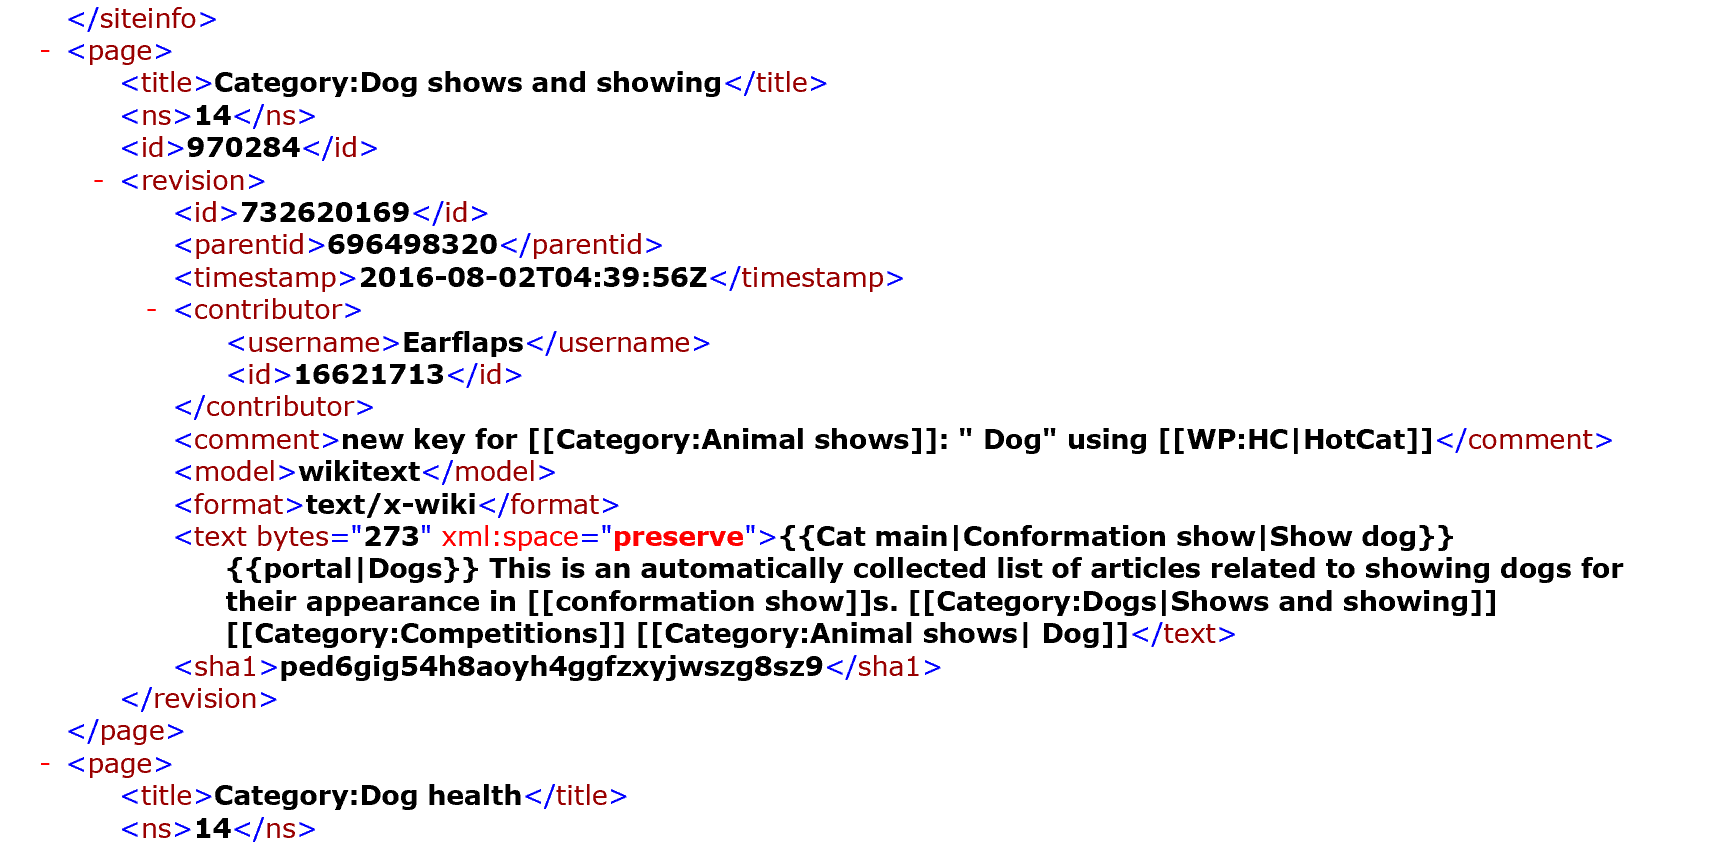

Now let's use nltk to tokenize and clean up the text

In [4]:
import nltk

In [5]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
text = textlist[0].childNodes[0].data.lower()
ttext = tokenizer.tokenize(text)
print(ttext)

['cat', 'main', 'conformation', 'show', 'show', 'dog', 'portal', 'dogs', 'this', 'is', 'an', 'automatically', 'collected', 'list', 'of', 'articles', 'related', 'to', 'showing', 'dogs', 'for', 'their', 'appearance', 'in', 'conformation', 'show', 's', 'category', 'dogs', 'shows', 'and', 'showing', 'category', 'competitions', 'category', 'animal', 'shows', 'dog']


The above article was a category. Lets see what happens for a true article with links, etc in the text. Looking at the list of titles, the 9th title, 'Kennel', looks like an article

In [ ]:
# print text of 9th article
text = textlist[8].childNodes[0].data.lower()
print(text)
ttext = tokenizer.tokenize(text)
print(ttext)

Use topic modeling to see how similar articles are:

refs: http://www.datasciencebytes.com/bytes/2014/12/30/topic-modeling-of-shakespeare-characters/
    http://www.datasciencebytes.com/bytes/2014/11/20/using-topic-modeling-to-find-related-blog-posts/
    
Steps:

	(1) tokenize all articles in corpus, remove stop words, rare words
    
    (2) create a dictionary consisting of all unique words in the corpus; the dictionary assigns an integer id to each word: dictionary = corpora.Dictionary(texts)
    
    - to see mapping btwn words and their ids: print(dictionary.token2id)
    
    (3) convert articles to vectors using bag-of-words document representation: each article is represented by one vector where each vector element represents a word id-word count pair (doc2bow)
    
    (4) initialize a model: model = models.<modelname>(corpus,..)
    
    (5) use the model to transform vectors: corpus_transformed = model[corpus]
    
    (6) serialize the corpus to disk if you will be iterating over the transformed corpus multiple times and if the transformation is costly: corpora.MmCorpus.serialize('/path/corpus.mm', corpus) <-- Market Matrix format
    
	- to load a corpus iterator from a Matrix Market file: corpus = corpora.MmCorpus('/path/corpus.mm')
	
    - to view contents of a corpus: print(list(corpus))
	
    - to save the model (e.g. lsi): model.save('/path/modelname.lsi')
    
	- to load the model: model = models.LsiModel.load('/path/modelname.lsi')
    
    (7) make similarity matrix

In [6]:
import pandas as pd
from collections import defaultdict
from gensim import corpora, models, similarities

C:\Users\melanie\Anaconda3\envs\cdips2017\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
# organize articles into a dataframe...exclude articles of short length? 
min_length = 1 #50  # minimum word count
word_data = [(title.childNodes[0].data, tokenizer.tokenize(text.childNodes[0].data.lower()))
             for title, text in zip(titlelist, textlist)
             if len(tokenizer.tokenize(text.childNodes[0].data.lower())) >= min_length]
word_data_df = pd.DataFrame(word_data, columns=['title', 'words'])
word_data_df.to_csv('word_data_df.csv')
word_data_df.head()

,title,words
0,Category:Dog shows and showing,"[cat, main, conformation, show, show, dog, por..."
1,Category:Dog health,"[this, is, a, collection, of, articles, about,..."
2,Category:Dog organizations,"[this, is, an, automatically, collected, list,..."
3,Category:Dog sports,"[this, is, an, automatically, accumulated, lis..."
4,Category:Dogs as pets,"[category, dogs, pets, category, mammals, as, ..."


In [ ]:
word_data_df.tail()

In [8]:
# construct dictionary, i.e. mapping btwn word ids and their freq of occurrence in the whole corpus
line_list = word_data_df['words'].values
dictionary = corpora.Dictionary(line_list)
# filter dictionary to remove stopwords and words occurring < min_count times
# need to run nltk.download() to download stopwords file -> downloaded into C:\Users\melanie\AppData\Roaming\nltk_data
stop_words = nltk.corpus.stopwords.words('english') 
min_count = 2
stop_ids = [dictionary.token2id[word] for word in stop_words
            if word in dictionary.token2id]
rare_ids = [id for id, freq in dictionary.dfs.items()
            if freq < min_count]
dictionary.filter_tokens(stop_ids + rare_ids)
dictionary.compactify()

In [9]:
# convert corpus to vectors using bag-of-words representation, i.e. tuples of word indices and word counts
corpus = [dictionary.doc2bow(words) for words in line_list]

In [10]:
# serialize corpus to disk (market matrix format)
corpora.mmcorpus.MmCorpus.serialize('wiki.mm', corpus) # we should build model, then serialize the model
# initialize transformation on input data with TF-IDF
# the TF-IDF model converts raw word counts to a value more indicative of the importance of each word 
# (offsets word count with how often a word occurs in entire corpus so rare words have greater value)
tfidf = models.TfidfModel(corpus)

In [17]:
# construct model
lsi = models.lsimodel.LsiModel(corpus=tfidf[corpus], id2word=dictionary, num_topics=10) 
lsi.save('wiki.lsi')
for i, topic in enumerate(lsi.print_topics(5)[:3]):
    print('Topic: ', format(i))
    print(str(topic).replace(' + ', '\n')) 
    print('') 

Topic:  0
(0, '-0.309*"ref"
-0.266*"cat"
-0.227*"cats"
-0.200*"dog"
-0.167*"name"
-0.156*"journal"
-0.127*"cite"
-0.123*"title"
-0.102*"meat"
-0.099*"url"')

Topic:  1
(1, '0.632*"bailys"
0.277*"hunt"
0.258*"foxhounds"
0.241*"england"
0.228*"directory"
0.170*"harriers"
0.167*"name"
0.166*"beagles"
0.156*"hunting"
0.152*"packs"')

Topic:  2
(2, '-0.383*"breeds"
-0.243*"breed"
-0.240*"list"
-0.194*"fictional"
-0.171*"pets"
-0.156*"types"
-0.152*"dog"
-0.148*"dogs"
-0.146*"commons"
-0.135*"individual"')



Analysis of article topics

ref: http://www.datasciencebytes.com/bytes/2014/12/31/analysis-of-shakespeare-character-speech-topics/

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

In [19]:
titles = word_data_df['title']

In [20]:
# use gensim to create similarity matrix
matsim = similarities.MatrixSimilarity(lsi[tfidf[corpus]], num_best=6)

In [21]:
# for the first 10 articles, print most similar articles and their similarity scores
for sims in list(matsim)[:10]:
    title_index = sims[0][0]
    print(titles[title_index]) 
    for other_title_index, score in sims[1:]:
        print('\t', titles[other_title_index], ' ', score) 

Category:Dog shows and showing
	 Category:Dog-related professions and professionals   0.947237670422
	 Category:Dog sports   0.89924788475
	 Category:Dog types   0.862879276276
	 Bog Dog   0.855496346951
	 Category:Dog breeds   0.831113398075
Category:Dog health
	 Category:Cat health   0.984833300114
	 Category:Dog law   0.912496387959
	 Category:Dog training and behavior   0.814541578293
	 Category:Dog equipment   0.771264910698
	 Category:Cat equipment   0.766750156879
Category:Dog organizations
	 Category:Dog-related professions and professionals   0.843377709389
	 Category:Dog shows and showing   0.805034160614
	 Category:Dog training and behavior   0.786815106869
	 Category:Cat organizations   0.757948875427
	 Category:Dog sports   0.727003455162
Category:Dog sports
	 Category:Dog shows and showing   0.89924788475
	 Category:Dog training and behavior   0.850112199783
	 Category:Dog-related professions and professionals   0.845990717411
	 Category:Dog law   0.80079883337
	 Bog Dog 

Issues/questions: 

-Why are the similarity scores so low? Compare with Tonatiuh's script, where scores are around 0.9. We expect scores to be high since these articles are about dogs (or cats). But then maybe the tfidf transformation lowers the count value of words like 'dogs' and 'cats' because they appear so frequently across our entire corpus..

A: turns out setting num_topics=5 (or any number less than default of 200) will increase the scores. This makes sense, since num_topics is the number of requested topics/latent dimensions. 

-Will the scores improve if we add a filtering step (e.g. remove articles of type 'category' or 'file', which have less text and more metadata than true wiki articles)? or filter out articles with small word counts?

-Should try applying different models: LDA, RP, HDP; see https://radimrehurek.com/gensim/tut2.html#available-transformations

In [22]:
# project first article into the first 10 dimensions, i.e. those containing the most information 
lsi[tfidf[corpus[0]]][:10]

[(0, -0.10516879736282024),
 (1, -0.022625568986918303),
 (2, -0.23207856489871945),
 (3, -0.1225149766049472),
 (4, -0.047938856999297723),
 (5, 0.050648965730716616),
 (6, 0.0029354137615808179),
 (7, -0.058605118574760487),
 (8, -0.074726375821184812),
 (9, -0.037409068838722387)]

In [23]:
# plot projection of articles onto 2 axes/topics defined by the LSI model; print 10 most impt words above plot
def format_topic_coeffs(topic):
    """Return a list of coefficent, word tuples with coefficent truncated to 
    3 decimal places.
    """
    return [(format(coeff), word) for coeff, word in topic]

def plot_axes(x=0, y=1, model=lsi, corpus=corpus, 
              tfidf=tfidf, titles=titles):
    """Plot each article title according to the projection of its text 
    into the given x and y topic axes of model.
    
    :param x: the index of the x axis to plot
    :param y: the index of the y axis to plot
    :param model: the gensim model to project into
    :param corpus: the gensim corpus of documents
    :param tfidf: a tfidf model for converting documents into tfidf space
    :param titles: a list of article titles
    """
    x_data = defaultdict(list) 
    y_data = defaultdict(list) 
    arts = defaultdict(list)  
    print('x topic:')
    pprint(format_topic_coeffs(model.show_topic(x)))
    print('')
    print('y topic:') 
    pprint(format_topic_coeffs(model.show_topic(y)))
    for title, doc in zip(titles, corpus):
        x_data[0].append((model[tfidf[doc]][x][1]))
        y_data[0].append((model[tfidf[doc]][y][1]))
        arts[0].append(title)
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    plt.scatter(x_data[0], y_data[0], s=40)
    for art, x, y in zip(arts[0], x_data[0], y_data[0]):
        ax.annotate(str(art), xy=(x, y), xycoords='data', xytext=(1, 1), 
        textcoords='offset points', size=10)
        

x topic:
[('ref', -0.30885704748220144),
 ('cat', -0.26578087615864071),
 ('cats', -0.22748480698046739),
 ('dog', -0.19968445773561355),
 ('name', -0.16744482238906122),
 ('journal', -0.15553221914269855),
 ('cite', -0.12721086025132974),
 ('title', -0.12279694680045866),
 ('meat', -0.1019729091670414),
 ('url', -0.098942404857432387)]

y topic:
[('bailys', 0.63239441882487624),
 ('hunt', 0.27725103933463735),
 ('foxhounds', 0.25809467221850296),
 ('england', 0.2412164500874211),
 ('directory', 0.22808029271122132),
 ('harriers', 0.17047525758107404),
 ('name', 0.16657041008309795),
 ('beagles', 0.16557986497510074),
 ('hunting', 0.15568450471420869),
 ('packs', 0.15248945019608884)]


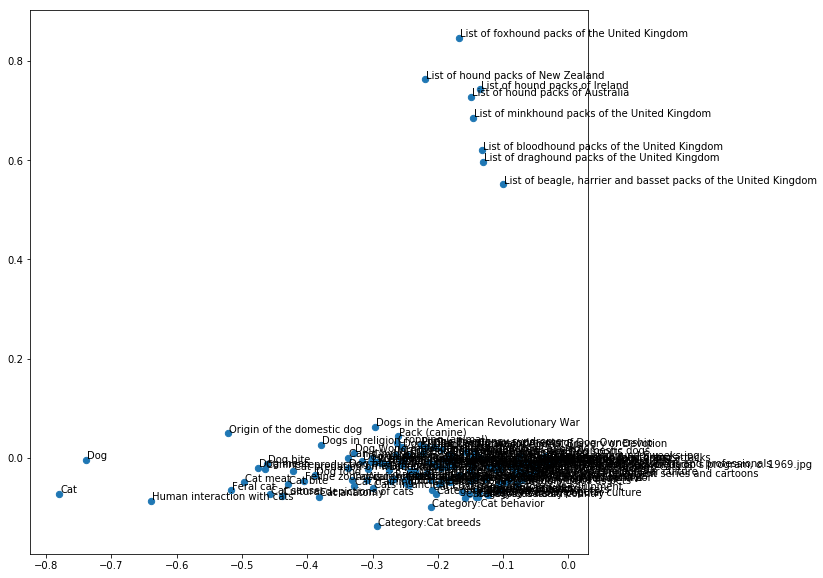

In [24]:
# y-axis separates articles about dog/hound packs in British commonwealth from all other articles
plot_axes(x=0, y=1)

x topic:
[('breeds', -0.38280002203610353),
 ('breed', -0.24288708273992052),
 ('list', -0.24004595781846827),
 ('fictional', -0.19380540842963909),
 ('pets', -0.17127440542967889),
 ('types', -0.15553357096262913),
 ('dog', -0.1519638876953672),
 ('dogs', -0.14838817715486832),
 ('commons', -0.14602135547487086),
 ('individual', -0.13504167793556704)]

y topic:
[('cats', 0.42242326108480371),
 ('dog', -0.35610059733021326),
 ('cat', 0.34824770818933382),
 ('pets', 0.21511956832476847),
 ('breeds', -0.20188109475320096),
 ('breed', -0.16059710757660586),
 ('mammals', 0.15438442864444663),
 ('country', 0.13097591006266485),
 ('equipment', 0.11229626592559716),
 ('cafe', 0.11153790594233066)]


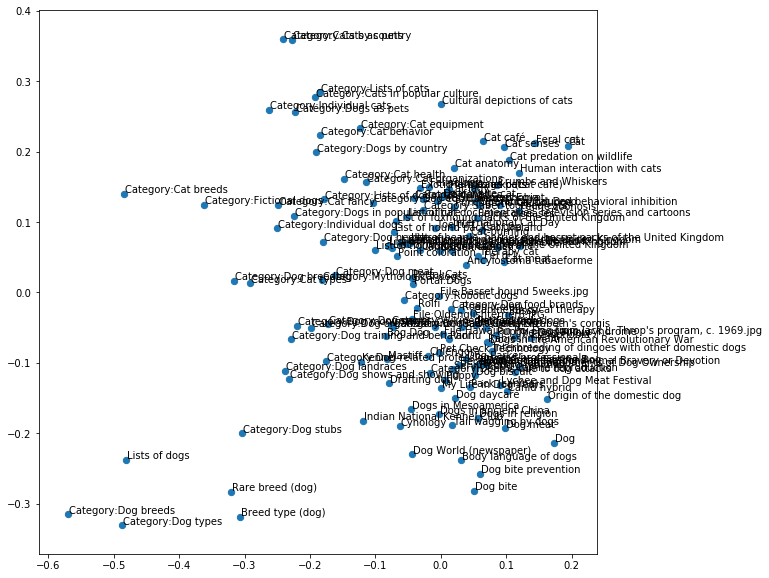

In [25]:
plot_axes(x=2, y=3)

x topic:
[('pets', 0.42082176472736998),
 ('fictional', -0.35715573404453227),
 ('mammals', 0.30492645559806786),
 ('popular', -0.20142654903340437),
 ('individual', -0.19784577278496557),
 ('meat', -0.18950053742240133),
 ('culture', -0.18739175757536944),
 ('lists', 0.18643626439659169),
 ('canines', -0.17836234616529525),
 ('country', 0.17470833024782209)]

y topic:
[('fictional', -0.32543005630839522),
 ('pets', -0.30740236159825968),
 ('cat', 0.2925812894141322),
 ('mammals', -0.23118677308978605),
 ('breeds', 0.21010838629893122),
 ('dogs', -0.1959694127560756),
 ('individual', -0.18972343453510404),
 ('cafe', 0.18302991164579074),
 ('popular', -0.16660002201297042),
 ('lists', -0.16308856142601971)]


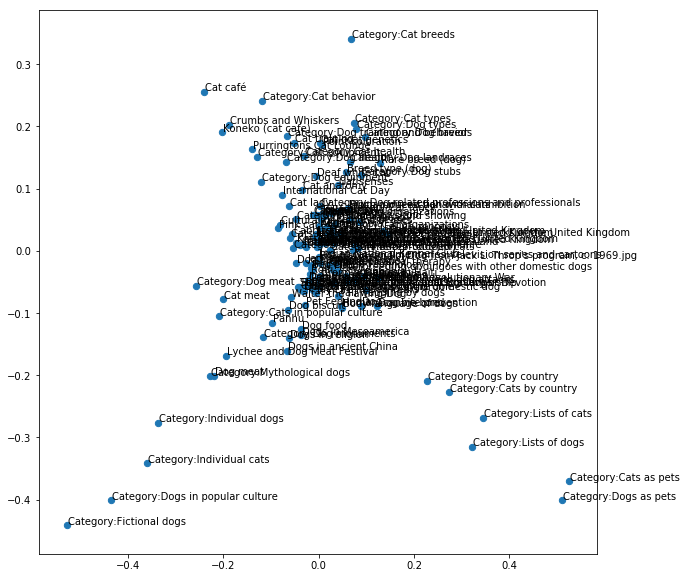

In [26]:
plot_axes(x=4, y=5)